In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")
plt.style.use("fivethirtyeight")

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) *100


c:\Users\alkrd\Desktop\graduation_project\the_project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
country_trend_data_path = "C:/Users/alkrd/Desktop/graduation_project/the_project/Classification/output/regions/north_america_australia/genral_labeled_data_with_relative_traffic_rates/Lifestyle/extended_data/australia.csv"

regressors = []

regressors_data = []

for regressor in regressors:
    data = pd.read_csv(regressor["path"], parse_dates=["date"])
    data.set_index("date", inplace=True)
    data.rename(columns={"value": regressor["label"]}, inplace=True)
    regressors_data.append(data)

country_trend_data = pd.read_csv(country_trend_data_path, parse_dates=["date"])
country_trend_data.set_index("date", inplace=True)


# Merge the DataFrames
data = country_trend_data.join(
    regressors_data,
    how="left",
)

print(data.head())
print(list(data.columns))
print(data.index)

            score
date             
2012-01-01     77
2012-01-02     65
2012-01-03     63
2012-01-04     64
2012-01-05     65
['score']
DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2017-04-25', '2017-04-26', '2017-04-27', '2017-04-28',
               '2017-04-29', '2017-04-30', '2017-05-01', '2017-05-02',
               '2017-05-03', '2017-05-04'],
              dtype='datetime64[ns]', name='date', length=1951, freq=None)


In [3]:
# configuations
split_date = pd.to_datetime("2016-02-01")
fig_size_config = (20,5)
testing_monitoring_lower_bound = datetime(2016, 4, 1)
testing_monitoring_upper_bound = datetime(2016, 9, 1)
tight_testing_monitoring_lower_bound = datetime(2016, 4, 1)
tight_testing_monitoring_upper_bound = datetime(2016, 9, 1)

type(split_date)

pandas._libs.tslibs.timestamps.Timestamp

[]

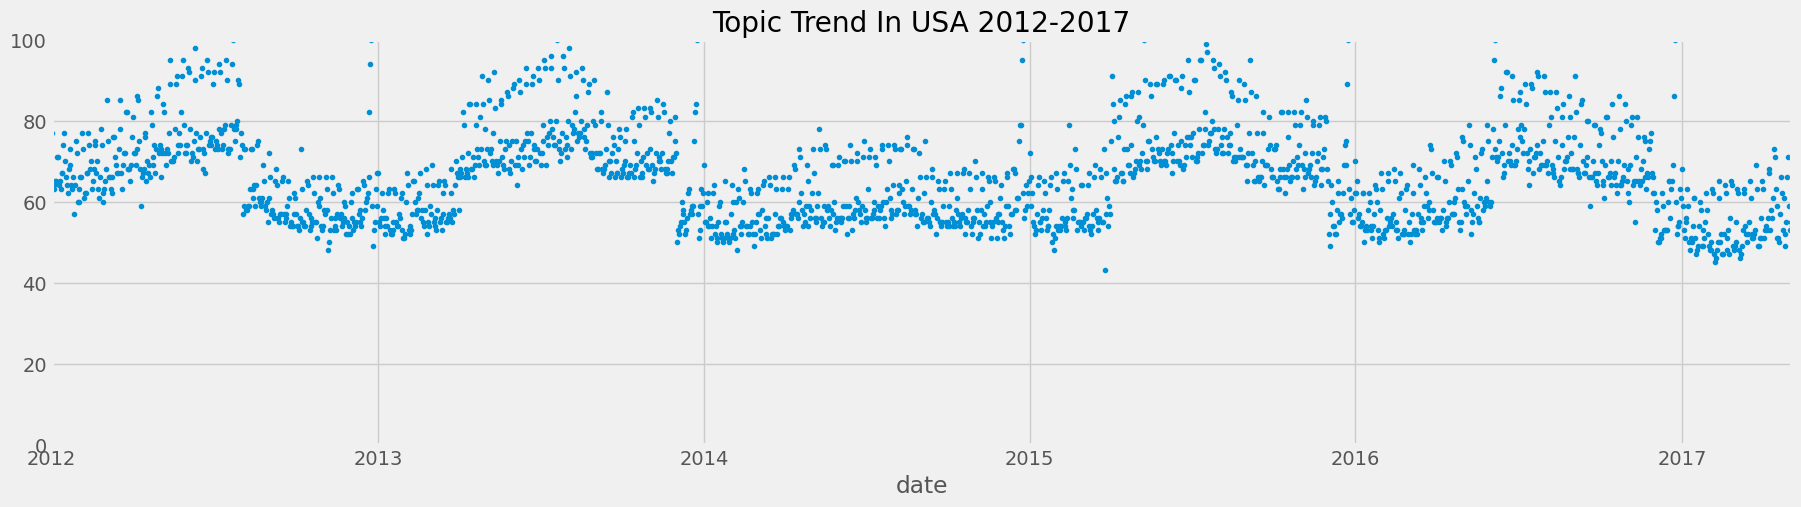

In [4]:
color_palette = sns.color_palette()

for column in data.columns:
    data[column] = pd.to_numeric(data[column], errors='coerce')

data = data.dropna()

for i, column in enumerate(data.columns):
    data[column].plot(
        style=".",
        figsize=fig_size_config,
        ms=6,
        color=color_palette[i % len(color_palette)],  # Cycle through the color palette
        title="Topic Trend In USA 2012-2017",
        ylim=(0, 100)
    )

plt.plot()

In [5]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
def create_features(df, label=None):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
    
    X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekday','season']]
    
    if label:
        y = df[label]
        return X,y
    return X


In [6]:
X, y = create_features(data, label='score')
features_and_target = pd.concat([X, y], axis=1)
print(features_and_target.dtypes)
features_and_target.head(5)


hour             int32
dayofweek        int32
quarter          int32
month            int32
year             int32
dayofyear        int32
dayofmonth       int32
weekday       category
season        category
score            int64
dtype: object


,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekday,season,score
date,,,,,,,,,,
2012-01-01,0,6,1,1,2012,1,1,Sunday,Winter,77
2012-01-02,0,0,1,1,2012,2,2,Monday,Winter,65
2012-01-03,0,1,1,1,2012,3,3,Tuesday,Winter,63
2012-01-04,0,2,1,1,2012,4,4,Wednesday,Winter,64
2012-01-05,0,3,1,1,2012,5,5,Thursday,Winter,65


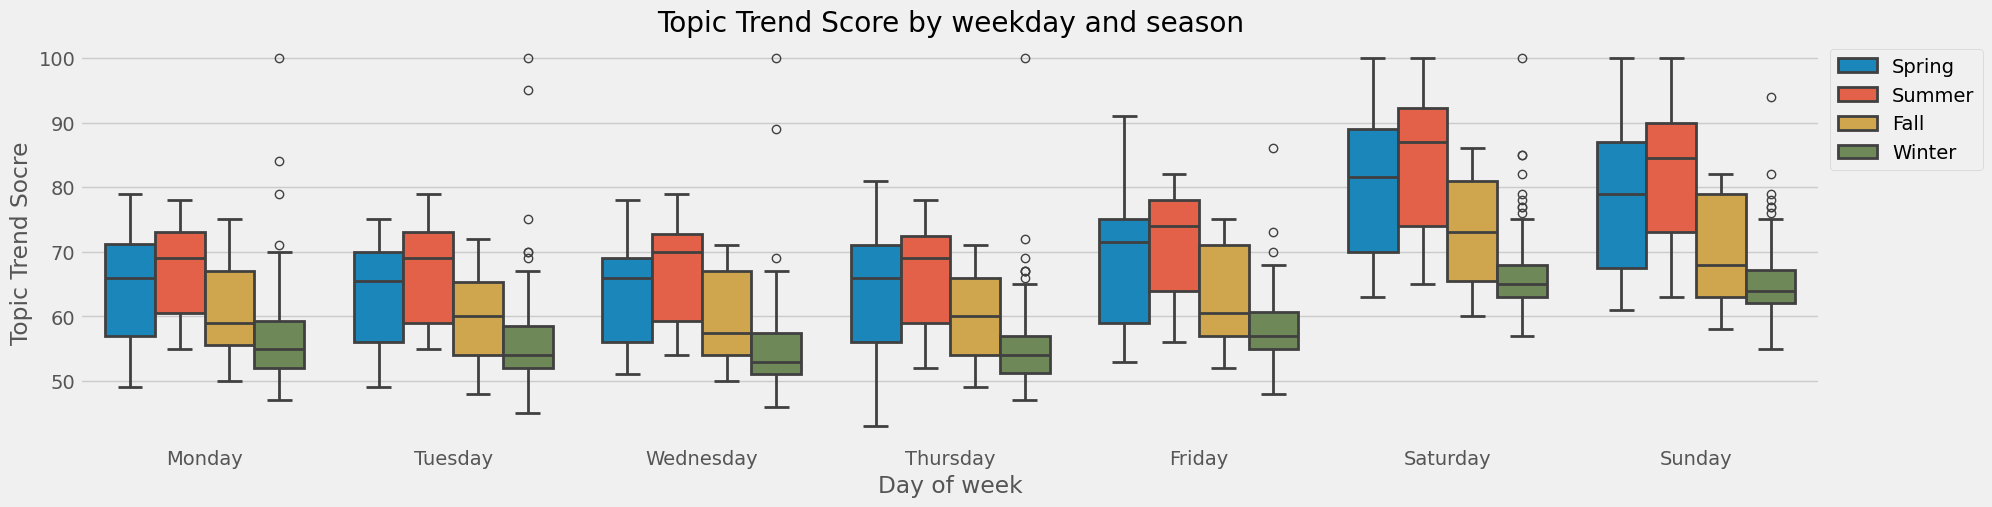

In [7]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(
    data=features_and_target.dropna(),
    x="weekday",
    y="score",
    hue="season",
    ax=ax,
    linewidth=2,
)

ax.set_title("Topic Trend Score by weekday and season")
ax.set_xlabel('Day of week')
ax.set_ylabel('Topic Trend Socre')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

Column names: Index(['score'], dtype='object')


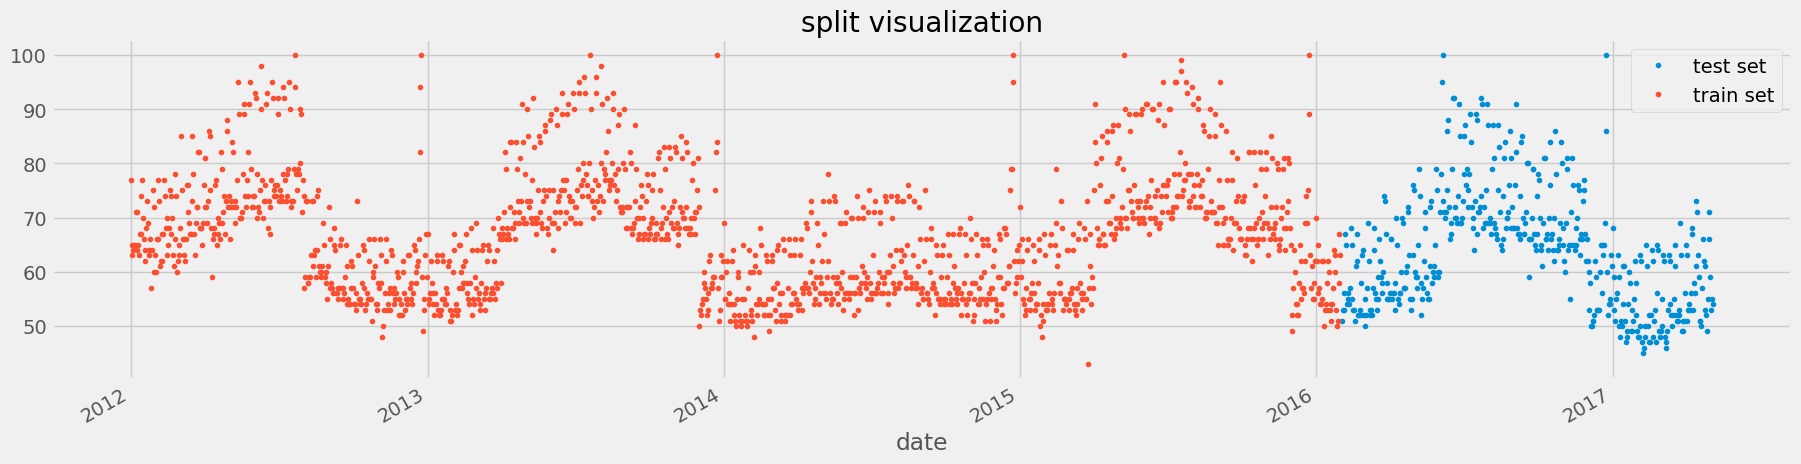

In [8]:
# Print the column names to verify
print("Column names:", data.columns)


# Split the data into train and test subsets
train_subset = data.loc[data.index < split_date].copy()
test_subset = data.loc[data.index > split_date].copy()

# Plotting them
test_subset \
    .rename(columns={'score': 'test set'}) \
    .join(train_subset.rename(columns={'score': 'train set'}), how='outer', lsuffix='_test', rsuffix='_train') \
    .plot(figsize=fig_size_config, ms=6, title='split visualization', style=".")
plt.show()

In [9]:
# rename the date and target columns to make them suitable for the prophet model
Pmodel_train_subset = train_subset.reset_index() \
    .rename(columns={
        'date':'ds',
        'score':'y'
    })

Pmodel_train_subset.head()
    

,ds,y
0,2012-01-01,77
1,2012-01-02,65
2,2012-01-03,63
3,2012-01-04,64
4,2012-01-05,65


In [10]:
%%time
model = Prophet()

for regressor in regressors:
    model.add_regressor(regressor["label"])

model.fit(Pmodel_train_subset)


# initial = 24.60884529352456
# diplomacy + economy + elections + war = 18.276949095894377
# diplomacy + economy + elections = 17.690909082684154
# diplomacy + economy + elections + immigration = 10.895234941447406
# diplomacy + economy + elections + immigration + war = 10.381891890285619


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


CPU times: total: 0 ns
Wall time: 355 ms


In [11]:
Pmodel_test_subset = test_subset.reset_index() \
    .rename(columns={
        'date':'ds',
        'score':'y' 
    })

forecasting_result = model.predict(Pmodel_test_subset)

In [12]:
forecasting_result.head(4)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-02-02,70.570247,51.656114,64.080331,70.570247,70.570247,-12.656391,-12.656391,-12.656391,-3.924689,-3.924689,-3.924689,-8.731702,-8.731702,-8.731702,0.0,0.0,0.0,57.913856
1,2016-02-03,70.572399,51.402814,63.756734,70.572399,70.572399,-13.057430,-13.057430,-13.057430,-4.623176,-4.623176,-4.623176,-8.434255,-8.434255,-8.434255,0.0,0.0,0.0,57.514969
2,2016-02-04,70.574552,52.020558,64.436229,70.574552,70.574552,-12.359752,-12.359752,-12.359752,-4.195639,-4.195639,-4.195639,-8.164113,-8.164113,-8.164113,0.0,0.0,0.0,58.214800
3,2016-02-05,70.576705,55.494083,68.118658,70.576705,70.576705,-8.776947,-8.776947,-8.776947,-0.853224,-0.853224,-0.853224,-7.923722,-7.923722,-7.923722,0.0,0.0,0.0,61.799758


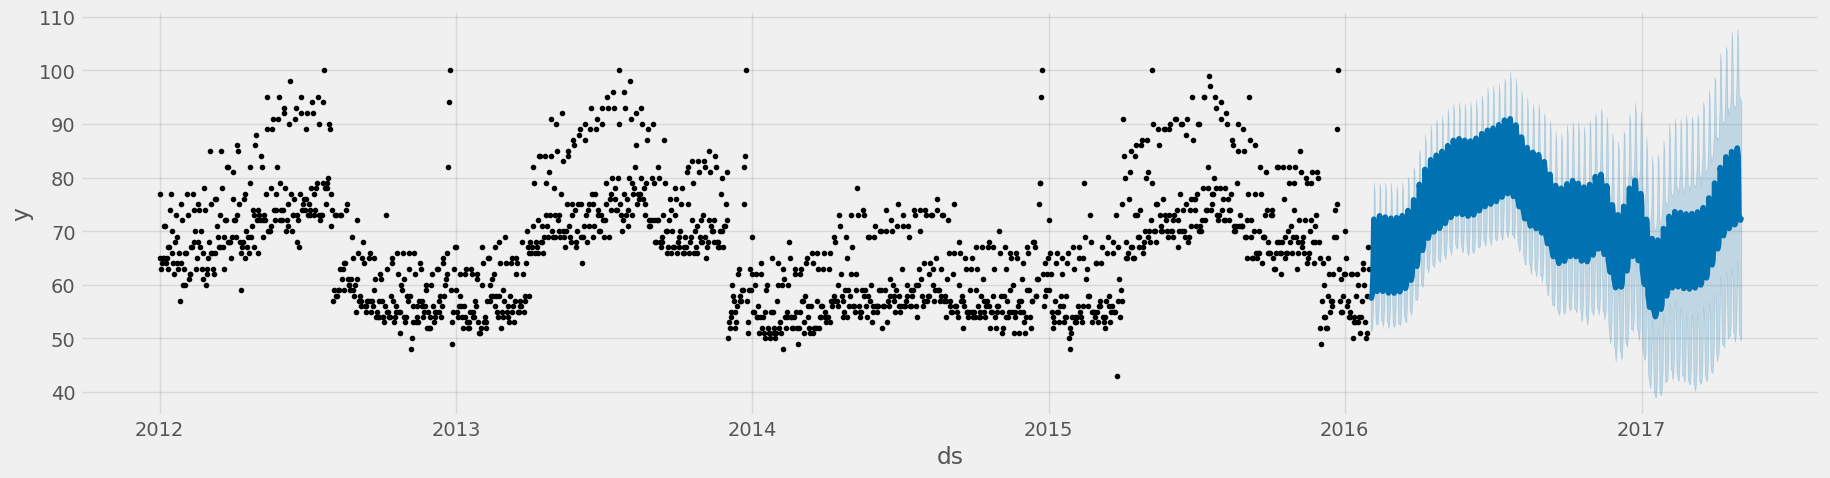

In [13]:
fig, ax = plt.subplots(figsize=fig_size_config)
fig = model.plot(forecasting_result, ax=ax)
plt.show()

# Note:
# the dark points are the predicted values, the light shadow represent the upper and
# lower bound of reasonable the prediction intervals/limits (as I understood)

# the intervals get wider as the prediction date gets further

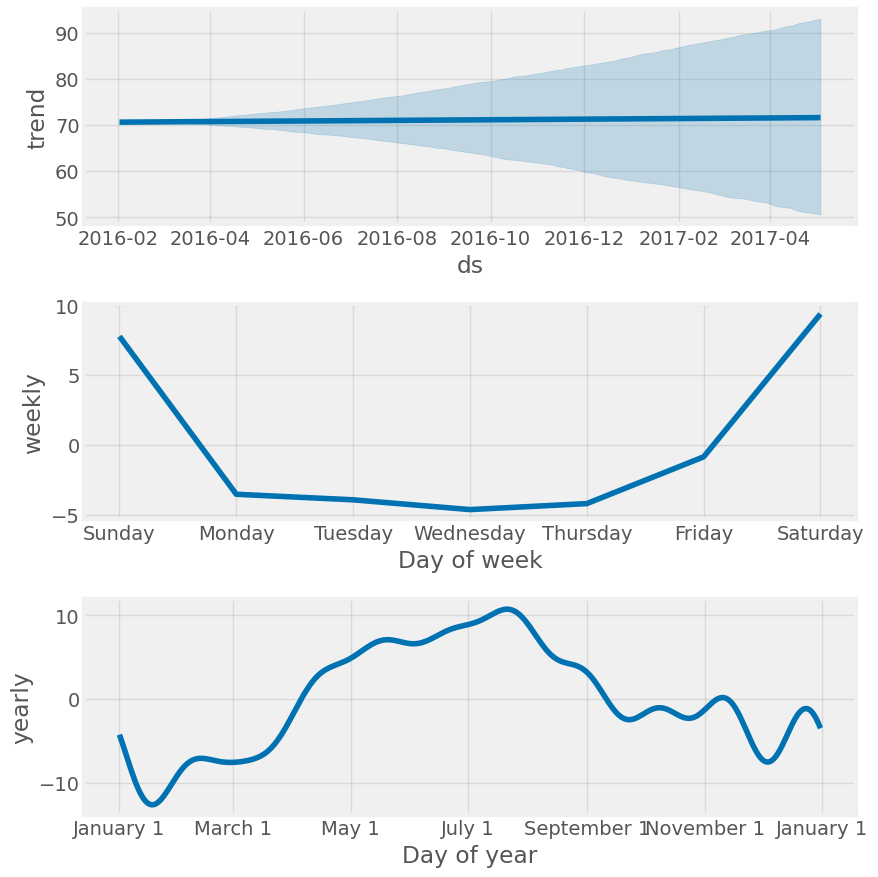

In [14]:
fig = model.plot_components(forecasting_result)
plt.show()

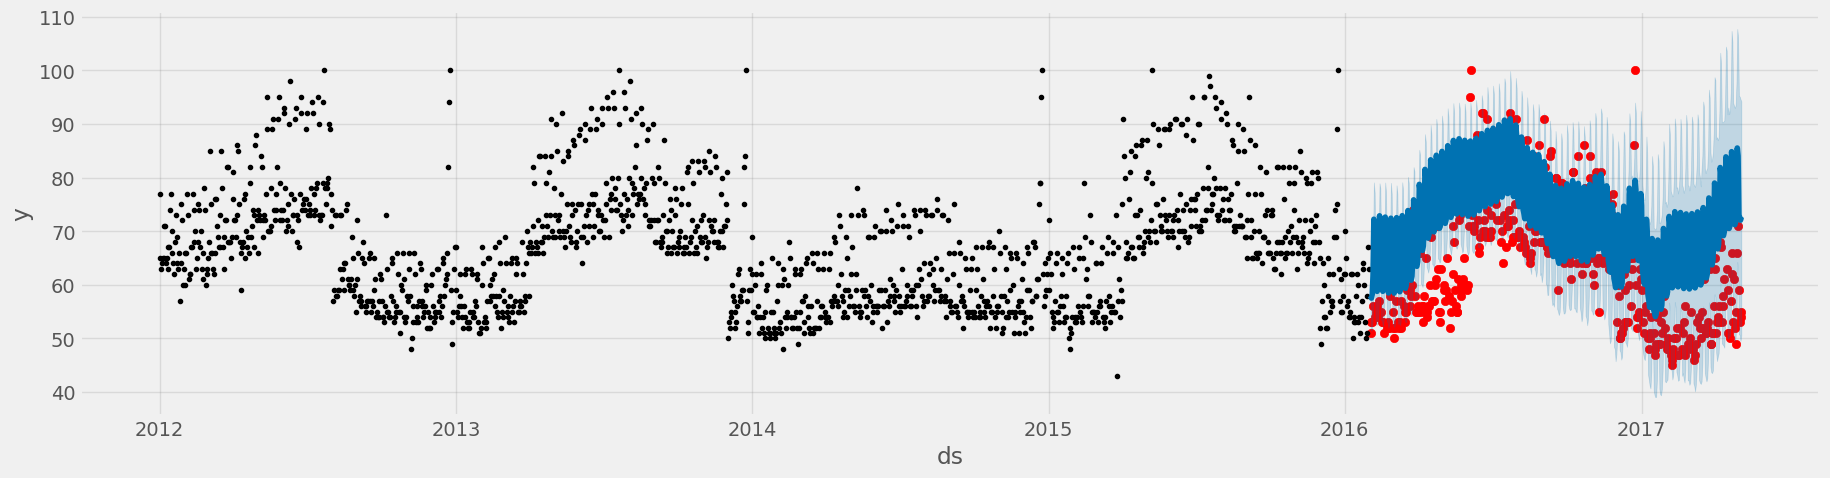

In [15]:
# comparing predictions to real data
f, ax = plt.subplots(figsize=fig_size_config)
ax.scatter(test_subset.index, test_subset['score'], color='r')
fig = model.plot(forecasting_result, ax=ax)

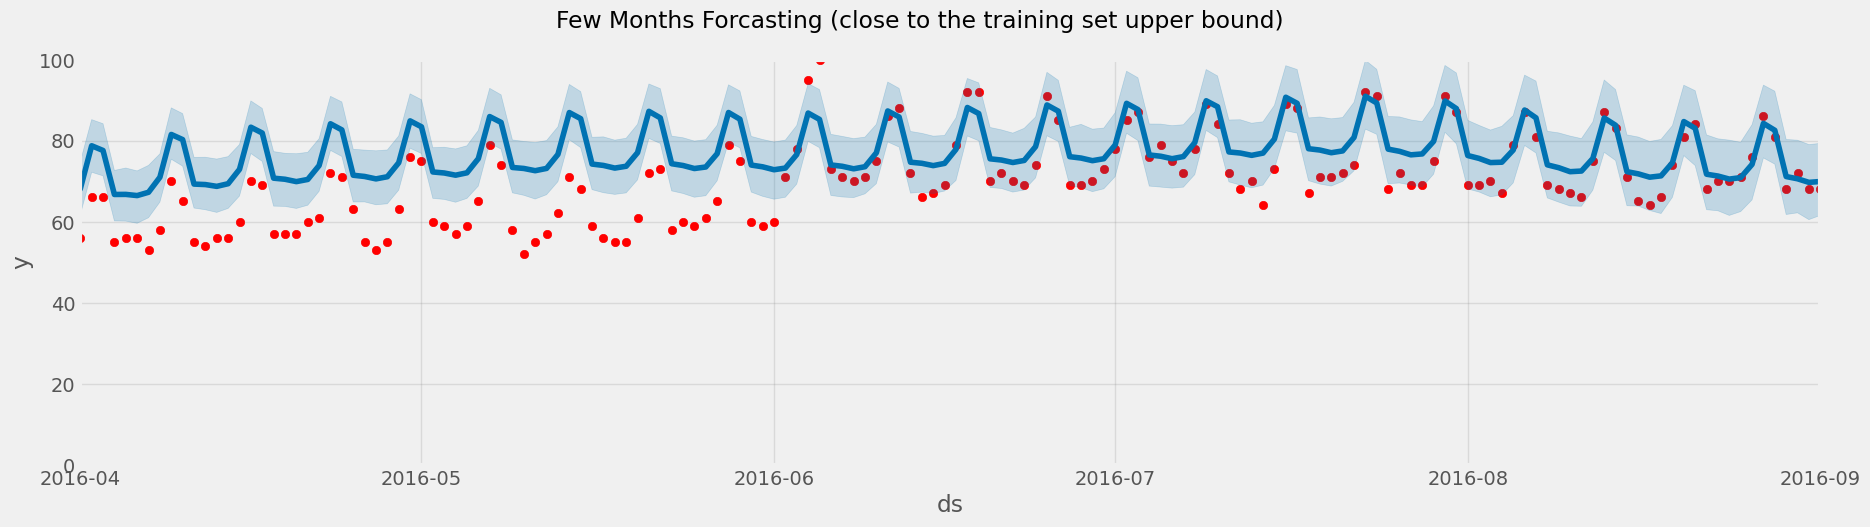

In [16]:

fig, ax = plt.subplots(figsize=fig_size_config)
ax.scatter(test_subset.index, test_subset["score"], color="r")
fig = model.plot(forecasting_result, ax=ax)
ax.set_xbound( 
    lower=testing_monitoring_lower_bound,
    upper=testing_monitoring_upper_bound
)
ax.set_ylim(0,100)
plot = plt.suptitle("Few Months Forcasting (close to the training set upper bound)")

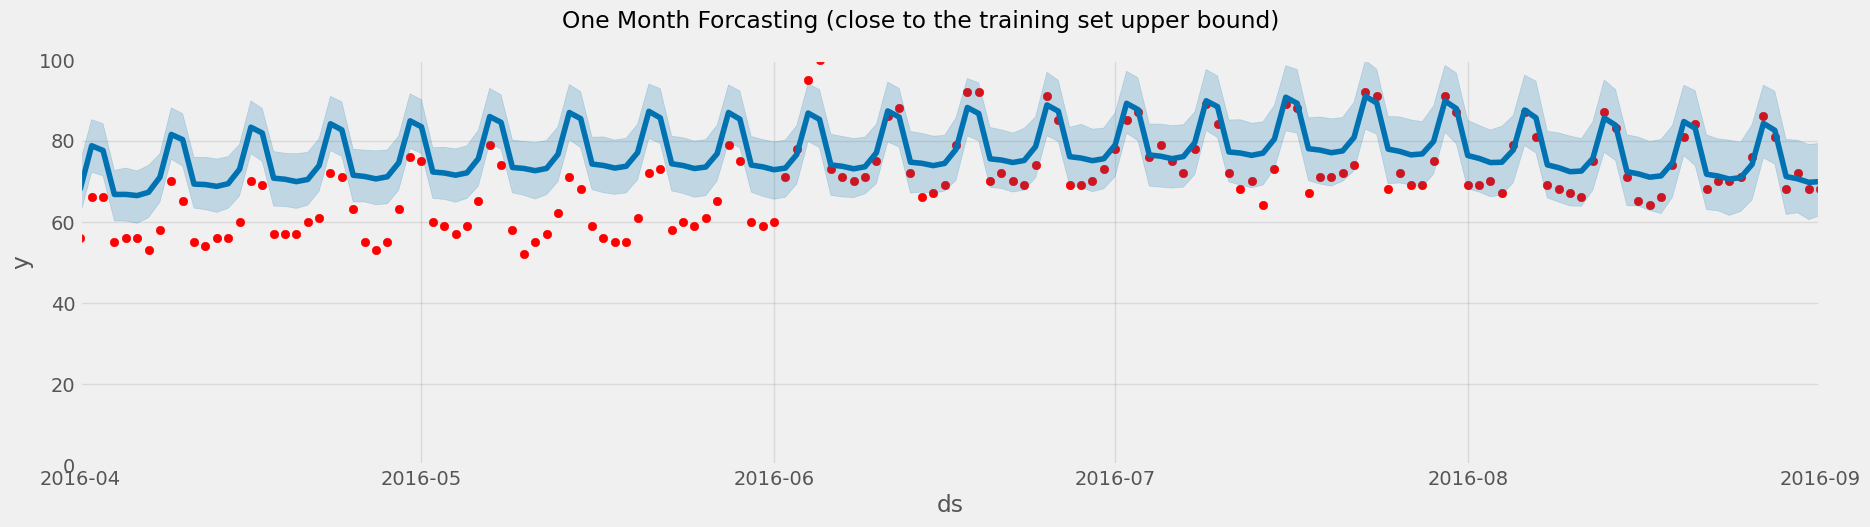

In [17]:
# closer look
fig, ax = plt.subplots(figsize=fig_size_config)
ax.scatter(test_subset.index, test_subset["score"], color="r")
fig = model.plot(forecasting_result, ax=ax)
ax.set_xbound( 
    lower=tight_testing_monitoring_lower_bound,
    upper=tight_testing_monitoring_upper_bound
)
ax.set_ylim(0,100)
plot = plt.suptitle("One Month Forcasting (close to the training set upper bound)")

In [18]:
# Evaluate using error metrics 
MSE = np.sqrt(mean_squared_error(y_true=test_subset['score'], y_pred=forecasting_result['yhat']))
print(MSE)

9.23081059418206


In [19]:
MAE = mean_absolute_error(y_true=test_subset['score'], y_pred=forecasting_result['yhat'])
print(MAE)

7.601787240340392


In [20]:
MAPE = mean_absolute_percentage_error(y_true=test_subset['score'], y_pred=forecasting_result['yhat'])
print(MAPE)


12.914412081144167


In [21]:
# predict the future
# assuming that the future starts after the training dataset date range.
future = model.make_future_dataframe(periods=358, freq='d', include_history=False)

for regressor in regressors:
    label = regressor['label']
    future[label] = data[label].mean()
    print(label)

forecast = model.predict(future)
print(forecast[['ds', 'yhat']])


            ds       yhat
0   2016-02-01  57.987827
1   2016-02-02  57.913856
2   2016-02-03  57.514969
3   2016-02-04  58.214800
4   2016-02-05  61.799758
..         ...        ...
353 2017-01-19  54.526705
354 2017-01-20  57.968201
355 2017-01-21  68.341183
356 2017-01-22  66.952008
357 2017-01-23  55.918886

[358 rows x 2 columns]
